In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.stats.mstats import mquantiles
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/data_set_hackathon.csv')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


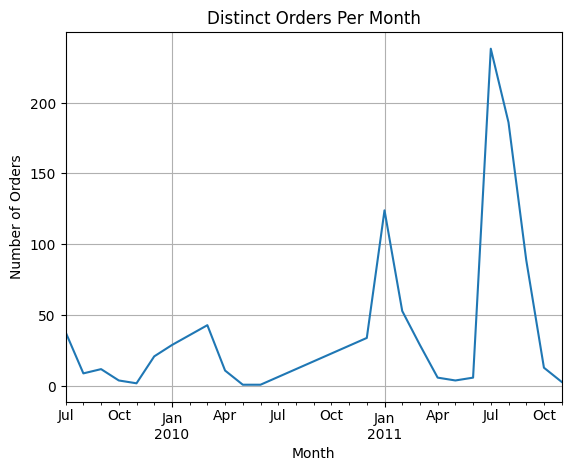

In [57]:
# Handle missing values
# Check for presence of 'Items' column and handle missing data
df['Items'] = df['Items'].fillna(0) if 'Items' in df.columns else 0
df = df.dropna(subset=['order_date', 'requested_delivery_date', 'Customer Order Code'])

# Parse dates
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Filter data to only include years 2009-2011
df = df[(df['order_date'].dt.year >= 2009) & (df['order_date'].dt.year <= 2011)]

# Create 'Month' column for grouping
df['Month'] = df['order_date'].dt.to_period('M')

# 1. Forecast number of distinct orders per month
distinct_orders = df.groupby('Month')['Customer Order Code'].nunique()

# Plot the number of distinct orders per month
distinct_orders.plot(kind='line', title='Distinct Orders Per Month', ylabel='Number of Orders', xlabel='Month')
plt.grid()
plt.show()

In [58]:
# STEP 1: Mark Urgent Orders
df['urgent_flag'] = np.where(df['requested_delivery_date'] < df['order_date'], 1, 0)

# STEP 2: Aggregate to monthly
# Convert 'Month' column (Period type) to a datetime index if necessary
df['Month'] = df['order_date'].dt.to_period('M').dt.to_timestamp('M')  # End-of-month timestamp
monthly_distinct_orders = df.groupby('Month')['Customer Order Code'].nunique().to_frame('distinct_orders')

# Aggregate the urgent flag as well, e.g., count or proportion
monthly_urgent_counts = df.groupby('Month')['urgent_flag'].sum()
monthly_total_orders = df.groupby('Month')['Customer Order Code'].count()
monthly_urgent_prop = (monthly_urgent_counts / monthly_total_orders).fillna(0)

# Merge the urgent proportion (or counts) into the main DataFrame
monthly_data = monthly_distinct_orders.join(monthly_urgent_prop.rename('urgent_prop'))

# Ensure chronological ordering
monthly_data = monthly_data.sort_index()

In [59]:
###################################
# STEP 3: Prepare data for SARIMAX #
###################################
# Ensure the index is a DatetimeIndex
print("Index before conversion:", monthly_data.index)
monthly_data.index = pd.to_datetime(monthly_data.index)
print("Index after pd.to_datetime:", monthly_data.index)

# Set a monthly frequency if not already set
if monthly_data.index.freq is None:
    monthly_data = monthly_data.asfreq('M')
print("Data index frequency:", monthly_data.index.freq)

# Check for NaNs
print("Check for NaNs in monthly_data:")
print(monthly_data.isna().sum())

# Since we have NaNs in distinct_orders and urgent_prop, we must handle them
# For example, we can drop these NaN rows or fill them:
monthly_data = monthly_data.dropna()

# Target and exogenous variables
y = monthly_data['distinct_orders']
X = monthly_data[['urgent_prop']]  # Adjust if you have other regressors

###################################
# STEP 4: Split data into train/test
###################################
# We are training up to end of 2011 and forecasting first 5 months of 2012
train = monthly_data.loc[:'2011-12-31']
test = monthly_data.loc['2012-01-01': '2012-05-31']

y_train, y_test = train['distinct_orders'], test['distinct_orders']
X_train, X_test = train[['urgent_prop']], test[['urgent_prop']]

print("\nTraining data date range:", y_train.index.min(), "to", y_train.index.max())
print("Testing data date range:", y_test.index.min(), "to", y_test.index.max())

# Check for NaNs again after dropping
print("\nCheck for NaNs in y_train and X_train:")
print("y_train NaNs:", y_train.isna().sum())
print("X_train NaNs:\n", X_train.isna().sum())
print("Check for NaNs in y_test and X_test:")
print("y_test NaNs:", y_test.isna().sum())
print("X_test NaNs:\n", X_test.isna().sum())

###################################
# STEP 5: SARIMAX Parameter Grid Search
###################################
p = d = q = range(0, 3)
seasonal_period = [12]  # monthly data with yearly seasonality
seasonal_pdq = [(x[0], x[1], x[2], m) for x in itertools.product(p, d, q) for m in seasonal_period]

best_aic = np.inf
best_params = None

print("\nBeginning parameter search...")
for param in itertools.product(p, d, q):
    for param_seasonal in seasonal_pdq:
        print(f"Trying SARIMAX{param}x{param_seasonal}")
        # Attempt to fit the model - if it fails, we want to see the error
        model = SARIMAX(y_train, 
                        exog=X_train, 
                        order=param, 
                        seasonal_order=param_seasonal, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = (param, param_seasonal)
            print(f"New best AIC: {best_aic} with parameters {best_params}")

if best_params is None:
    print("\nNo valid parameter combination was found. Please check your data and parameters.")
else:
    print("\nBest SARIMAX parameters:", best_params, "with AIC:", best_aic)
    # Fit the best model
    best_model = SARIMAX(y_train, 
                         exog=X_train, 
                         order=best_params[0], 
                         seasonal_order=best_params[1], 
                         enforce_stationarity=False, 
                         enforce_invertibility=False)
    best_results = best_model.fit(disp=False)
    print(best_results.summary())

    forecast_steps = 5
    # Forecast the next 5 months using the test exogenous data
    forecast = best_results.get_forecast(steps=forecast_steps, exog=X_test)
    fc_mean = forecast.predicted_mean

    # Evaluate the forecast
    plt.figure(figsize=(10,5))
    plt.plot(y_train.index, y_train, label='Training')
    plt.plot(y_test.index, y_test, label='Test', color='orange')
    plt.plot(fc_mean.index, fc_mean, label='Forecast', color='green')
    plt.legend()
    plt.title('Forecast of Distinct Monthly Orders')
    plt.show()

    mae = mean_absolute_error(y_test, fc_mean)
    mse = mean_squared_error(y_test, fc_mean)
    print("MAE:", mae)
    print("MSE:", mse)

Index before conversion: DatetimeIndex(['2009-07-31', '2009-08-31', '2009-09-30', '2009-10-31',
               '2009-11-30', '2009-12-31', '2010-01-31', '2010-02-28',
               '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30',
               '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30'],
              dtype='datetime64[ns]', name='Month', freq=None)
Index after pd.to_datetime: DatetimeIndex(['2009-07-31', '2009-08-31', '2009-09-30', '2009-10-31',
               '2009-11-30', '2009-12-31', '2010-01-31', '2010-02-28',
               '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30',
               '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30'],
              dtype='datetime6

C:\Users\Berry\AppData\Local\Temp\ipykernel_32868\1617701227.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = monthly_data.asfreq('M')
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Loca

Trying SARIMAX(0, 0, 0)x(1, 2, 2, 12)
Trying SARIMAX(0, 0, 0)x(2, 0, 0, 12)
Trying SARIMAX(0, 0, 0)x(2, 0, 1, 12)
Trying SARIMAX(0, 0, 0)x(2, 0, 2, 12)
Trying SARIMAX(0, 0, 0)x(2, 1, 0, 12)
Trying SARIMAX(0, 0, 0)x(2, 1, 1, 12)
Trying SARIMAX(0, 0, 0)x(2, 1, 2, 12)
Trying SARIMAX(0, 0, 0)x(2, 2, 0, 12)
Trying SARIMAX(0, 0, 0)x(2, 2, 1, 12)
Trying SARIMAX(0, 0, 0)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 0, 1)x(0, 0, 0, 12)
Trying SARIMAX(0, 0, 1)x(0, 0, 1, 12)
Trying SARIMAX(0, 0, 1)x(0, 0, 2, 12)
Trying SARIMAX(0, 0, 1)x(0, 1, 0, 12)
Trying SARIMAX(0, 0, 1)x(0, 1, 1, 12)
Trying SARIMAX(0, 0, 1)x(0, 1, 2, 12)
Trying SARIMAX(0, 0, 1)x(0, 2, 0, 12)
Trying SARIMAX(0, 0, 1)x(0, 2, 1, 12)
Trying SARIMAX(0, 0, 1)x(0, 2, 2, 12)
Trying SARIMAX(0, 0, 1)x(1, 0, 0, 12)
Trying SARIMAX(0, 0, 1)x(1, 0, 1, 12)
Trying SARIMAX(0, 0, 1)x(1, 0, 2, 12)
Trying SARIMAX(0, 0, 1)x(1, 1, 0, 12)
Trying SARIMAX(0, 0, 1)x(1, 1, 1, 12)
Trying SARIMAX(0, 0, 1)x(1, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(0, 0, 1)x(1, 2, 0, 12)
Trying SARIMAX(0, 0, 1)x(1, 2, 1, 12)
Trying SARIMAX(0, 0, 1)x(1, 2, 2, 12)
Trying SARIMAX(0, 0, 1)x(2, 0, 0, 12)
Trying SARIMAX(0, 0, 1)x(2, 0, 1, 12)
Trying SARIMAX(0, 0, 1)x(2, 0, 2, 12)
Trying SARIMAX(0, 0, 1)x(2, 1, 0, 12)
Trying SARIMAX(0, 0, 1)x(2, 1, 1, 12)
Trying SARIMAX(0, 0, 1)x(2, 1, 2, 12)
Trying SARIMAX(0, 0, 1)x(2, 2, 0, 12)
Trying SARIMAX(0, 0, 1)x(2, 2, 1, 12)
Trying SARIMAX(0, 0, 1)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(0, 0, 2)x(0, 0, 0, 12)
Trying SARIMAX(0, 0, 2)x(0, 0, 1, 12)
Trying SARIMAX(0, 0, 2)x(0, 0, 2, 12)
Trying SARIMAX(0, 0, 2)x(0, 1, 0, 12)
Trying SARIMAX(0, 0, 2)x(0, 1, 1, 12)
Trying SARIMAX(0, 0, 2)x(0, 1, 2, 12)
Trying SARIMAX(0, 0, 2)x(0, 2, 0, 12)
Trying SARIMAX(0, 0, 2)x(0, 2, 1, 12)
Trying SARIMAX(0, 0, 2)x(0, 2, 2, 12)
Trying SARIMAX(0, 0, 2)x(1, 0, 0, 12)
Trying SARIMAX(0, 0, 2)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(0, 0, 2)x(1, 0, 2, 12)
Trying SARIMAX(0, 0, 2)x(1, 1, 0, 12)
Trying SARIMAX(0, 0, 2)x(1, 1, 1, 12)
Trying SARIMAX(0, 0, 2)x(1, 1, 2, 12)
Trying SARIMAX(0, 0, 2)x(1, 2, 0, 12)
Trying SARIMAX(0, 0, 2)x(1, 2, 1, 12)
Trying SARIMAX(0, 0, 2)x(1, 2, 2, 12)
Trying SARIMAX(0, 0, 2)x(2, 0, 0, 12)
Trying SARIMAX(0, 0, 2)x(2, 0, 1, 12)
Trying SARIMAX(0, 0, 2)x(2, 0, 2, 12)
Trying SARIMAX(0, 0, 2)x(2, 1, 0, 12)
Trying SARIMAX(0, 0, 2)x(2, 1, 1, 12)
Trying SARIMAX(0, 0, 2)x(2, 1, 2, 12)
Trying SARIMAX(0, 0, 2)x(2, 2, 0, 12)
Trying SARIMAX(0, 0, 2)x(2, 2, 1, 12)
Trying SARIMAX(0, 0, 2)x(2, 2, 2, 12)
Trying SARIMAX(0, 1, 0)x(0, 0, 0, 12)
Trying SARIMAX(0, 1, 0)x(0, 0, 1, 12)
Trying SARIMAX(0, 1, 0)x(0, 0, 2, 12)
Trying SARIMAX(0, 1, 0)x(0, 1, 0, 12)
Trying SARIMAX(0, 1, 0)x(0, 1, 1, 12)
Trying SARIMAX(0, 1, 0)x(0, 1, 2, 12)
Trying SARIMAX(0, 1, 0)x(0, 2, 0, 12)
Trying SARIMAX(0, 1, 0)x(0, 2, 1, 12)
Trying SARIMAX(0, 1, 0)x(0, 2, 2, 12)
Trying SARIMAX(0, 1, 0)x(1, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(0, 1, 0)x(1, 0, 1, 12)
Trying SARIMAX(0, 1, 0)x(1, 0, 2, 12)
Trying SARIMAX(0, 1, 0)x(1, 1, 0, 12)
Trying SARIMAX(0, 1, 0)x(1, 1, 1, 12)
Trying SARIMAX(0, 1, 0)x(1, 1, 2, 12)
Trying SARIMAX(0, 1, 0)x(1, 2, 0, 12)
Trying SARIMAX(0, 1, 0)x(1, 2, 1, 12)
Trying SARIMAX(0, 1, 0)x(1, 2, 2, 12)
Trying SARIMAX(0, 1, 0)x(2, 0, 0, 12)
Trying SARIMAX(0, 1, 0)x(2, 0, 1, 12)
Trying SARIMAX(0, 1, 0)x(2, 0, 2, 12)
Trying SARIMAX(0, 1, 0)x(2, 1, 0, 12)
Trying SARIMAX(0, 1, 0)x(2, 1, 1, 12)
Trying SARIMAX(0, 1, 0)x(2, 1, 2, 12)
Trying SARIMAX(0, 1, 0)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 1, 0)x(2, 2, 1, 12)
Trying SARIMAX(0, 1, 0)x(2, 2, 2, 12)
Trying SARIMAX(0, 1, 1)x(0, 0, 0, 12)
Trying SARIMAX(0, 1, 1)x(0, 0, 1, 12)
Trying SARIMAX(0, 1, 1)x(0, 0, 2, 12)
Trying SARIMAX(0, 1, 1)x(0, 1, 0, 12)
Trying SARIMAX(0, 1, 1)x(0, 1, 1, 12)
Trying SARIMAX(0, 1, 1)x(0, 1, 2, 12)
Trying SARIMAX(0, 1, 1)x(0, 2, 0, 12)
Trying SARIMAX(0, 1, 1)x(0, 2, 1, 12)
Trying SARIMAX(0, 1, 1)x(0, 2, 2, 12)
Trying SARIMAX(0, 1, 1)x(1, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(0, 1, 1)x(1, 0, 1, 12)
Trying SARIMAX(0, 1, 1)x(1, 0, 2, 12)
Trying SARIMAX(0, 1, 1)x(1, 1, 0, 12)
Trying SARIMAX(0, 1, 1)x(1, 1, 1, 12)
Trying SARIMAX(0, 1, 1)x(1, 1, 2, 12)
Trying SARIMAX(0, 1, 1)x(1, 2, 0, 12)
Trying SARIMAX(0, 1, 1)x(1, 2, 1, 12)
Trying SARIMAX(0, 1, 1)x(1, 2, 2, 12)
Trying SARIMAX(0, 1, 1)x(2, 0, 0, 12)
Trying SARIMAX(0, 1, 1)x(2, 0, 1, 12)
Trying SARIMAX(0, 1, 1)x(2, 0, 2, 12)
Trying SARIMAX(0, 1, 1)x(2, 1, 0, 12)
Trying SARIMAX(0, 1, 1)x(2, 1, 1, 12)
Trying SARIMAX(0, 1, 1)x(2, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 1, 1)x(2, 2, 0, 12)
Trying SARIMAX(0, 1, 1)x(2, 2, 1, 12)
Trying SARIMAX(0, 1, 1)x(2, 2, 2, 12)
Trying SARIMAX(0, 1, 2)x(0, 0, 0, 12)
Trying SARIMAX(0, 1, 2)x(0, 0, 1, 12)
Trying SARIMAX(0, 1, 2)x(0, 0, 2, 12)
Trying SARIMAX(0, 1, 2)x(0, 1, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 1, 2)x(0, 1, 1, 12)
Trying SARIMAX(0, 1, 2)x(0, 1, 2, 12)
Trying SARIMAX(0, 1, 2)x(0, 2, 0, 12)
Trying SARIMAX(0, 1, 2)x(0, 2, 1, 12)
Trying SARIMAX(0, 1, 2)x(0, 2, 2, 12)
Trying SARIMAX(0, 1, 2)x(1, 0, 0, 12)
Trying SARIMAX(0, 1, 2)x(1, 0, 1, 12)
Trying SARIMAX(0, 1, 2)x(1, 0, 2, 12)
Trying SARIMAX(0, 1, 2)x(1, 1, 0, 12)
Trying SARIMAX(0, 1, 2)x(1, 1, 1, 12)
Trying SARIMAX(0, 1, 2)x(1, 1, 2, 12)
Trying SARIMAX(0, 1, 2)x(1, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 1, 2)x(1, 2, 1, 12)
Trying SARIMAX(0, 1, 2)x(1, 2, 2, 12)
Trying SARIMAX(0, 1, 2)x(2, 0, 0, 12)
Trying SARIMAX(0, 1, 2)x(2, 0, 1, 12)
Trying SARIMAX(0, 1, 2)x(2, 0, 2, 12)
Trying SARIMAX(0, 1, 2)x(2, 1, 0, 12)
Trying SARIMAX(0, 1, 2)x(2, 1, 1, 12)
Trying SARIMAX(0, 1, 2)x(2, 1, 2, 12)
Trying SARIMAX(0, 1, 2)x(2, 2, 0, 12)
Trying SARIMAX(0, 1, 2)x(2, 2, 1, 12)
Trying SARIMAX(0, 1, 2)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(0, 2, 0)x(0, 0, 0, 12)
Trying SARIMAX(0, 2, 0)x(0, 0, 1, 12)
Trying SARIMAX(0, 2, 0)x(0, 0, 2, 12)
Trying SARIMAX(0, 2, 0)x(0, 1, 0, 12)
Trying SARIMAX(0, 2, 0)x(0, 1, 1, 12)
Trying SARIMAX(0, 2, 0)x(0, 1, 2, 12)
Trying SARIMAX(0, 2, 0)x(0, 2, 0, 12)
Trying SARIMAX(0, 2, 0)x(0, 2, 1, 12)
Trying SARIMAX(0, 2, 0)x(0, 2, 2, 12)
Trying SARIMAX(0, 2, 0)x(1, 0, 0, 12)
Trying SARIMAX(0, 2, 0)x(1, 0, 1, 12)
Trying SARIMAX(0, 2, 0)x(1, 0, 2, 12)
Trying SARIMAX(0, 2, 0)x(1, 1, 0, 12)
Trying SARIMAX(0, 2, 0)x(1, 1, 1, 12)
Trying SARIMAX(0, 2, 0)x(1, 1, 2, 12)
Trying SARIMAX(0, 2, 0)x(1, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 2, 0)x(1, 2, 1, 12)
Trying SARIMAX(0, 2, 0)x(1, 2, 2, 12)
Trying SARIMAX(0, 2, 0)x(2, 0, 0, 12)
Trying SARIMAX(0, 2, 0)x(2, 0, 1, 12)
Trying SARIMAX(0, 2, 0)x(2, 0, 2, 12)
Trying SARIMAX(0, 2, 0)x(2, 1, 0, 12)
Trying SARIMAX(0, 2, 0)x(2, 1, 1, 12)
Trying SARIMAX(0, 2, 0)x(2, 1, 2, 12)
Trying SARIMAX(0, 2, 0)x(2, 2, 0, 12)
Trying SARIMAX(0, 2, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(0, 2, 0)x(2, 2, 2, 12)
Trying SARIMAX(0, 2, 1)x(0, 0, 0, 12)
Trying SARIMAX(0, 2, 1)x(0, 0, 1, 12)
Trying SARIMAX(0, 2, 1)x(0, 0, 2, 12)
Trying SARIMAX(0, 2, 1)x(0, 1, 0, 12)
Trying SARIMAX(0, 2, 1)x(0, 1, 1, 12)
Trying SARIMAX(0, 2, 1)x(0, 1, 2, 12)
Trying SARIMAX(0, 2, 1)x(0, 2, 0, 12)
Trying SARIMAX(0, 2, 1)x(0, 2, 1, 12)
Trying SARIMAX(0, 2, 1)x(0, 2, 2, 12)
Trying SARIMAX(0, 2, 1)x(1, 0, 0, 12)
Trying SARIMAX(0, 2, 1)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provi

Trying SARIMAX(0, 2, 1)x(1, 0, 2, 12)
Trying SARIMAX(0, 2, 1)x(1, 1, 0, 12)
Trying SARIMAX(0, 2, 1)x(1, 1, 1, 12)
Trying SARIMAX(0, 2, 1)x(1, 1, 2, 12)
Trying SARIMAX(0, 2, 1)x(1, 2, 0, 12)
Trying SARIMAX(0, 2, 1)x(1, 2, 1, 12)
Trying SARIMAX(0, 2, 1)x(1, 2, 2, 12)
Trying SARIMAX(0, 2, 1)x(2, 0, 0, 12)
Trying SARIMAX(0, 2, 1)x(2, 0, 1, 12)
Trying SARIMAX(0, 2, 1)x(2, 0, 2, 12)
Trying SARIMAX(0, 2, 1)x(2, 1, 0, 12)
Trying SARIMAX(0, 2, 1)x(2, 1, 1, 12)
Trying SARIMAX(0, 2, 1)x(2, 1, 2, 12)
Trying SARIMAX(0, 2, 1)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 2, 1)x(2, 2, 1, 12)
Trying SARIMAX(0, 2, 1)x(2, 2, 2, 12)
Trying SARIMAX(0, 2, 2)x(0, 0, 0, 12)
Trying SARIMAX(0, 2, 2)x(0, 0, 1, 12)
Trying SARIMAX(0, 2, 2)x(0, 0, 2, 12)
Trying SARIMAX(0, 2, 2)x(0, 1, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 2, 2)x(0, 1, 1, 12)
Trying SARIMAX(0, 2, 2)x(0, 1, 2, 12)
Trying SARIMAX(0, 2, 2)x(0, 2, 0, 12)
Trying SARIMAX(0, 2, 2)x(0, 2, 1, 12)
Trying SARIMAX(0, 2, 2)x(0, 2, 2, 12)
Trying SARIMAX(0, 2, 2)x(1, 0, 0, 12)
Trying SARIMAX(0, 2, 2)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 2, 2)x(1, 0, 2, 12)
Trying SARIMAX(0, 2, 2)x(1, 1, 0, 12)
Trying SARIMAX(0, 2, 2)x(1, 1, 1, 12)
Trying SARIMAX(0, 2, 2)x(1, 1, 2, 12)
Trying SARIMAX(0, 2, 2)x(1, 2, 0, 12)
Trying SARIMAX(0, 2, 2)x(1, 2, 1, 12)
Trying SARIMAX(0, 2, 2)x(1, 2, 2, 12)
Trying SARIMAX(0, 2, 2)x(2, 0, 0, 12)
Trying SARIMAX(0, 2, 2)x(2, 0, 1, 12)
Trying SARIMAX(0, 2, 2)x(2, 0, 2, 12)
Trying SARIMAX(0, 2, 2)x(2, 1, 0, 12)
Trying SARIMAX(0, 2, 2)x(2, 1, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(0, 2, 2)x(2, 1, 2, 12)
Trying SARIMAX(0, 2, 2)x(2, 2, 0, 12)
Trying SARIMAX(0, 2, 2)x(2, 2, 1, 12)
Trying SARIMAX(0, 2, 2)x(2, 2, 2, 12)
Trying SARIMAX(1, 0, 0)x(0, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(1, 0, 0)x(0, 0, 1, 12)
Trying SARIMAX(1, 0, 0)x(0, 0, 2, 12)
Trying SARIMAX(1, 0, 0)x(0, 1, 0, 12)
Trying SARIMAX(1, 0, 0)x(0, 1, 1, 12)
Trying SARIMAX(1, 0, 0)x(0, 1, 2, 12)
Trying SARIMAX(1, 0, 0)x(0, 2, 0, 12)
Trying SARIMAX(1, 0, 0)x(0, 2, 1, 12)
Trying SARIMAX(1, 0, 0)x(0, 2, 2, 12)
Trying SARIMAX(1, 0, 0)x(1, 0, 0, 12)
Trying SARIMAX(1, 0, 0)x(1, 0, 1, 12)
Trying SARIMAX(1, 0, 0)x(1, 0, 2, 12)
Trying SARIMAX(1, 0, 0)x(1, 1, 0, 12)
Trying SARIMAX(1, 0, 0)x(1, 1, 1, 12)
Trying SARIMAX(1, 0, 0)x(1, 1, 2, 12)
Trying SARIMAX(1, 0, 0)x(1, 2, 0, 12)
Trying SARIMAX(1, 0, 0)x(1, 2, 1, 12)
Trying SARIMAX(1, 0, 0)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(1, 0, 0)x(2, 0, 0, 12)
Trying SARIMAX(1, 0, 0)x(2, 0, 1, 12)
Trying SARIMAX(1, 0, 0)x(2, 0, 2, 12)
Trying SARIMAX(1, 0, 0)x(2, 1, 0, 12)
Trying SARIMAX(1, 0, 0)x(2, 1, 1, 12)
Trying SARIMAX(1, 0, 0)x(2, 1, 2, 12)
Trying SARIMAX(1, 0, 0)x(2, 2, 0, 12)
Trying SARIMAX(1, 0, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(1, 0, 0)x(2, 2, 2, 12)
Trying SARIMAX(1, 0, 1)x(0, 0, 0, 12)
Trying SARIMAX(1, 0, 1)x(0, 0, 1, 12)
Trying SARIMAX(1, 0, 1)x(0, 0, 2, 12)
Trying SARIMAX(1, 0, 1)x(0, 1, 0, 12)
Trying SARIMAX(1, 0, 1)x(0, 1, 1, 12)
Trying SARIMAX(1, 0, 1)x(0, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 0, 1)x(0, 2, 0, 12)
Trying SARIMAX(1, 0, 1)x(0, 2, 1, 12)
Trying SARIMAX(1, 0, 1)x(0, 2, 2, 12)
Trying SARIMAX(1, 0, 1)x(1, 0, 0, 12)
Trying SARIMAX(1, 0, 1)x(1, 0, 1, 12)
Trying SARIMAX(1, 0, 1)x(1, 0, 2, 12)
Trying SARIMAX(1, 0, 1)x(1, 1, 0, 12)
Trying SARIMAX(1, 0, 1)x(1, 1, 1, 12)
Trying SARIMAX(1, 0, 1)x(1, 1, 2, 12)
Trying SARIMAX(1, 0, 1)x(1, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 0, 1)x(1, 2, 1, 12)
Trying SARIMAX(1, 0, 1)x(1, 2, 2, 12)
Trying SARIMAX(1, 0, 1)x(2, 0, 0, 12)
Trying SARIMAX(1, 0, 1)x(2, 0, 1, 12)
Trying SARIMAX(1, 0, 1)x(2, 0, 2, 12)
Trying SARIMAX(1, 0, 1)x(2, 1, 0, 12)
Trying SARIMAX(1, 0, 1)x(2, 1, 1, 12)
Trying SARIMAX(1, 0, 1)x(2, 1, 2, 12)
Trying SARIMAX(1, 0, 1)x(2, 2, 0, 12)
Trying SARIMAX(1, 0, 1)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 0, 1)x(2, 2, 2, 12)
Trying SARIMAX(1, 0, 2)x(0, 0, 0, 12)
Trying SARIMAX(1, 0, 2)x(0, 0, 1, 12)
Trying SARIMAX(1, 0, 2)x(0, 0, 2, 12)
Trying SARIMAX(1, 0, 2)x(0, 1, 0, 12)
Trying SARIMAX(1, 0, 2)x(0, 1, 1, 12)
Trying SARIMAX(1, 0, 2)x(0, 1, 2, 12)
Trying SARIMAX(1, 0, 2)x(0, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 0, 2)x(0, 2, 1, 12)
Trying SARIMAX(1, 0, 2)x(0, 2, 2, 12)
Trying SARIMAX(1, 0, 2)x(1, 0, 0, 12)
Trying SARIMAX(1, 0, 2)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(1, 0, 2)x(1, 0, 2, 12)
Trying SARIMAX(1, 0, 2)x(1, 1, 0, 12)
Trying SARIMAX(1, 0, 2)x(1, 1, 1, 12)
Trying SARIMAX(1, 0, 2)x(1, 1, 2, 12)
Trying SARIMAX(1, 0, 2)x(1, 2, 0, 12)
Trying SARIMAX(1, 0, 2)x(1, 2, 1, 12)
Trying SARIMAX(1, 0, 2)x(1, 2, 2, 12)
Trying SARIMAX(1, 0, 2)x(2, 0, 0, 12)
Trying SARIMAX(1, 0, 2)x(2, 0, 1, 12)
Trying SARIMAX(1, 0, 2)x(2, 0, 2, 12)
Trying SARIMAX(1, 0, 2)x(2, 1, 0, 12)
Trying SARIMAX(1, 0, 2)x(2, 1, 1, 12)
Trying SARIMAX(1, 0, 2)x(2, 1, 2, 12)
Trying SARIMAX(1, 0, 2)x(2, 2, 0, 12)
Trying SARIMAX(1, 0, 2)x(2, 2, 1, 12)
Trying SARIMAX(1, 0, 2)x(2, 2, 2, 12)
Trying SARIMAX(1, 1, 0)x(0, 0, 0, 12)
Trying SARIMAX(1, 1, 0)x(0, 0, 1, 12)
Trying SARIMAX(1, 1, 0)x(0, 0, 2, 12)
Trying SARIMAX(1, 1, 0)x(0, 1, 0, 12)
Trying SARIMAX(1, 1, 0)x(0, 1, 1, 12)
Trying SARIMAX(1, 1, 0)x(0, 1, 2, 12)
Trying SARIMAX(1, 1, 0)x(0, 2, 0, 12)
Trying SARIMAX(1, 1, 0)x(0, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 1, 0)x(0, 2, 2, 12)
Trying SARIMAX(1, 1, 0)x(1, 0, 0, 12)
Trying SARIMAX(1, 1, 0)x(1, 0, 1, 12)
Trying SARIMAX(1, 1, 0)x(1, 0, 2, 12)
Trying SARIMAX(1, 1, 0)x(1, 1, 0, 12)
Trying SARIMAX(1, 1, 0)x(1, 1, 1, 12)
Trying SARIMAX(1, 1, 0)x(1, 1, 2, 12)
Trying SARIMAX(1, 1, 0)x(1, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(1, 1, 0)x(1, 2, 1, 12)
Trying SARIMAX(1, 1, 0)x(1, 2, 2, 12)
Trying SARIMAX(1, 1, 0)x(2, 0, 0, 12)
Trying SARIMAX(1, 1, 0)x(2, 0, 1, 12)
Trying SARIMAX(1, 1, 0)x(2, 0, 2, 12)
Trying SARIMAX(1, 1, 0)x(2, 1, 0, 12)
Trying SARIMAX(1, 1, 0)x(2, 1, 1, 12)
Trying SARIMAX(1, 1, 0)x(2, 1, 2, 12)
Trying SARIMAX(1, 1, 0)x(2, 2, 0, 12)
Trying SARIMAX(1, 1, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 1, 0)x(2, 2, 2, 12)
Trying SARIMAX(1, 1, 1)x(0, 0, 0, 12)
Trying SARIMAX(1, 1, 1)x(0, 0, 1, 12)
Trying SARIMAX(1, 1, 1)x(0, 0, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 1, 1)x(0, 1, 0, 12)
Trying SARIMAX(1, 1, 1)x(0, 1, 1, 12)
Trying SARIMAX(1, 1, 1)x(0, 1, 2, 12)
Trying SARIMAX(1, 1, 1)x(0, 2, 0, 12)
Trying SARIMAX(1, 1, 1)x(0, 2, 1, 12)
Trying SARIMAX(1, 1, 1)x(0, 2, 2, 12)
Trying SARIMAX(1, 1, 1)x(1, 0, 0, 12)
Trying SARIMAX(1, 1, 1)x(1, 0, 1, 12)
Trying SARIMAX(1, 1, 1)x(1, 0, 2, 12)
Trying SARIMAX(1, 1, 1)x(1, 1, 0, 12)
Trying SARIMAX(1, 1, 1)x(1, 1, 1, 12)
Trying SARIMAX(1, 1, 1)x(1, 1, 2, 12)
Trying SARIMAX(1, 1, 1)x(1, 2, 0, 12)
Trying SARIMAX(1, 1, 1)x(1, 2, 1, 12)
Trying SARIMAX(1, 1, 1)x(1, 2, 2, 12)
Trying SARIMAX(1, 1, 1)x(2, 0, 0, 12)
Trying SARIMAX(1, 1, 1)x(2, 0, 1, 12)
Trying SARIMAX(1, 1, 1)x(2, 0, 2, 12)
Trying SARIMAX(1, 1, 1)x(2, 1, 0, 12)
Trying SARIMAX(1, 1, 1)x(2, 1, 1, 12)
Trying SARIMAX(1, 1, 1)x(2, 1, 2, 12)
Trying SARIMAX(1, 1, 1)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 1, 1)x(2, 2, 1, 12)
Trying SARIMAX(1, 1, 1)x(2, 2, 2, 12)
Trying SARIMAX(1, 1, 2)x(0, 0, 0, 12)
Trying SARIMAX(1, 1, 2)x(0, 0, 1, 12)
Trying SARIMAX(1, 1, 2)x(0, 0, 2, 12)
Trying SARIMAX(1, 1, 2)x(0, 1, 0, 12)
Trying SARIMAX(1, 1, 2)x(0, 1, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 1, 2)x(0, 1, 2, 12)
Trying SARIMAX(1, 1, 2)x(0, 2, 0, 12)
Trying SARIMAX(1, 1, 2)x(0, 2, 1, 12)
Trying SARIMAX(1, 1, 2)x(0, 2, 2, 12)
Trying SARIMAX(1, 1, 2)x(1, 0, 0, 12)
Trying SARIMAX(1, 1, 2)x(1, 0, 1, 12)
Trying SARIMAX(1, 1, 2)x(1, 0, 2, 12)
Trying SARIMAX(1, 1, 2)x(1, 1, 0, 12)
Trying SARIMAX(1, 1, 2)x(1, 1, 1, 12)
Trying SARIMAX(1, 1, 2)x(1, 1, 2, 12)
Trying SARIMAX(1, 1, 2)x(1, 2, 0, 12)
Trying SARIMAX(1, 1, 2)x(1, 2, 1, 12)
Trying SARIMAX(1, 1, 2)x(1, 2, 2, 12)
Trying SARIMAX(1, 1, 2)x(2, 0, 0, 12)
Trying SARIMAX(1, 1, 2)x(2, 0, 1, 12)
Trying SARIMAX(1, 1, 2)x(2, 0, 2, 12)
Trying SARIMAX(1, 1, 2)x(2, 1, 0, 12)
Trying SARIMAX(1, 1, 2)x(2, 1, 1, 12)
Trying SARIMAX(1, 1, 2)x(2, 1, 2, 12)
Trying SARIMAX(1, 1, 2)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 1, 2)x(2, 2, 1, 12)
Trying SARIMAX(1, 1, 2)x(2, 2, 2, 12)
Trying SARIMAX(1, 2, 0)x(0, 0, 0, 12)
Trying SARIMAX(1, 2, 0)x(0, 0, 1, 12)
Trying SARIMAX(1, 2, 0)x(0, 0, 2, 12)
Trying SARIMAX(1, 2, 0)x(0, 1, 0, 12)
Trying SARIMAX(1, 2, 0)x(0, 1, 1, 12)
Trying SARIMAX(1, 2, 0)x(0, 1, 2, 12)
Trying SARIMAX(1, 2, 0)x(0, 2, 0, 12)
Trying SARIMAX(1, 2, 0)x(0, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 2, 0)x(0, 2, 2, 12)
Trying SARIMAX(1, 2, 0)x(1, 0, 0, 12)
Trying SARIMAX(1, 2, 0)x(1, 0, 1, 12)
Trying SARIMAX(1, 2, 0)x(1, 0, 2, 12)
Trying SARIMAX(1, 2, 0)x(1, 1, 0, 12)
Trying SARIMAX(1, 2, 0)x(1, 1, 1, 12)
Trying SARIMAX(1, 2, 0)x(1, 1, 2, 12)
Trying SARIMAX(1, 2, 0)x(1, 2, 0, 12)
Trying SARIMAX(1, 2, 0)x(1, 2, 1, 12)
Trying SARIMAX(1, 2, 0)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 2, 0)x(2, 0, 0, 12)
Trying SARIMAX(1, 2, 0)x(2, 0, 1, 12)
Trying SARIMAX(1, 2, 0)x(2, 0, 2, 12)
Trying SARIMAX(1, 2, 0)x(2, 1, 0, 12)
Trying SARIMAX(1, 2, 0)x(2, 1, 1, 12)
Trying SARIMAX(1, 2, 0)x(2, 1, 2, 12)
Trying SARIMAX(1, 2, 0)x(2, 2, 0, 12)
Trying SARIMAX(1, 2, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 2, 0)x(2, 2, 2, 12)
Trying SARIMAX(1, 2, 1)x(0, 0, 0, 12)
Trying SARIMAX(1, 2, 1)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(1, 2, 1)x(0, 0, 2, 12)
Trying SARIMAX(1, 2, 1)x(0, 1, 0, 12)
Trying SARIMAX(1, 2, 1)x(0, 1, 1, 12)
Trying SARIMAX(1, 2, 1)x(0, 1, 2, 12)
Trying SARIMAX(1, 2, 1)x(0, 2, 0, 12)
Trying SARIMAX(1, 2, 1)x(0, 2, 1, 12)
Trying SARIMAX(1, 2, 1)x(0, 2, 2, 12)
Trying SARIMAX(1, 2, 1)x(1, 0, 0, 12)
Trying SARIMAX(1, 2, 1)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 2, 1)x(1, 0, 2, 12)
Trying SARIMAX(1, 2, 1)x(1, 1, 0, 12)
Trying SARIMAX(1, 2, 1)x(1, 1, 1, 12)
Trying SARIMAX(1, 2, 1)x(1, 1, 2, 12)
Trying SARIMAX(1, 2, 1)x(1, 2, 0, 12)
Trying SARIMAX(1, 2, 1)x(1, 2, 1, 12)
Trying SARIMAX(1, 2, 1)x(1, 2, 2, 12)
Trying SARIMAX(1, 2, 1)x(2, 0, 0, 12)
Trying SARIMAX(1, 2, 1)x(2, 0, 1, 12)
Trying SARIMAX(1, 2, 1)x(2, 0, 2, 12)
Trying SARIMAX(1, 2, 1)x(2, 1, 0, 12)
Trying SARIMAX(1, 2, 1)x(2, 1, 1, 12)
Trying SARIMAX(1, 2, 1)x(2, 1, 2, 12)
Trying SARIMAX(1, 2, 1)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 2, 1)x(2, 2, 1, 12)
Trying SARIMAX(1, 2, 1)x(2, 2, 2, 12)
Trying SARIMAX(1, 2, 2)x(0, 0, 0, 12)
Trying SARIMAX(1, 2, 2)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(1, 2, 2)x(0, 0, 2, 12)
Trying SARIMAX(1, 2, 2)x(0, 1, 0, 12)
Trying SARIMAX(1, 2, 2)x(0, 1, 1, 12)
Trying SARIMAX(1, 2, 2)x(0, 1, 2, 12)
Trying SARIMAX(1, 2, 2)x(0, 2, 0, 12)
Trying SARIMAX(1, 2, 2)x(0, 2, 1, 12)
Trying SARIMAX(1, 2, 2)x(0, 2, 2, 12)
Trying SARIMAX(1, 2, 2)x(1, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 2, 2)x(1, 0, 1, 12)
Trying SARIMAX(1, 2, 2)x(1, 0, 2, 12)
Trying SARIMAX(1, 2, 2)x(1, 1, 0, 12)
Trying SARIMAX(1, 2, 2)x(1, 1, 1, 12)
Trying SARIMAX(1, 2, 2)x(1, 1, 2, 12)
Trying SARIMAX(1, 2, 2)x(1, 2, 0, 12)
Trying SARIMAX(1, 2, 2)x(1, 2, 1, 12)
Trying SARIMAX(1, 2, 2)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(1, 2, 2)x(2, 0, 0, 12)
Trying SARIMAX(1, 2, 2)x(2, 0, 1, 12)
Trying SARIMAX(1, 2, 2)x(2, 0, 2, 12)
Trying SARIMAX(1, 2, 2)x(2, 1, 0, 12)
Trying SARIMAX(1, 2, 2)x(2, 1, 1, 12)
Trying SARIMAX(1, 2, 2)x(2, 1, 2, 12)
Trying SARIMAX(1, 2, 2)x(2, 2, 0, 12)
Trying SARIMAX(1, 2, 2)x(2, 2, 1, 12)
Trying SARIMAX(1, 2, 2)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 0, 0)x(0, 0, 0, 12)
Trying SARIMAX(2, 0, 0)x(0, 0, 1, 12)
Trying SARIMAX(2, 0, 0)x(0, 0, 2, 12)
Trying SARIMAX(2, 0, 0)x(0, 1, 0, 12)
Trying SARIMAX(2, 0, 0)x(0, 1, 1, 12)
Trying SARIMAX(2, 0, 0)x(0, 1, 2, 12)
Trying SARIMAX(2, 0, 0)x(0, 2, 0, 12)
Trying SARIMAX(2, 0, 0)x(0, 2, 1, 12)
Trying SARIMAX(2, 0, 0)x(0, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(2, 0, 0)x(1, 0, 0, 12)
Trying SARIMAX(2, 0, 0)x(1, 0, 1, 12)
Trying SARIMAX(2, 0, 0)x(1, 0, 2, 12)
Trying SARIMAX(2, 0, 0)x(1, 1, 0, 12)
Trying SARIMAX(2, 0, 0)x(1, 1, 1, 12)
Trying SARIMAX(2, 0, 0)x(1, 1, 2, 12)
Trying SARIMAX(2, 0, 0)x(1, 2, 0, 12)
Trying SARIMAX(2, 0, 0)x(1, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 0, 0)x(1, 2, 2, 12)
Trying SARIMAX(2, 0, 0)x(2, 0, 0, 12)
Trying SARIMAX(2, 0, 0)x(2, 0, 1, 12)
Trying SARIMAX(2, 0, 0)x(2, 0, 2, 12)
Trying SARIMAX(2, 0, 0)x(2, 1, 0, 12)
Trying SARIMAX(2, 0, 0)x(2, 1, 1, 12)
Trying SARIMAX(2, 0, 0)x(2, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 0, 0)x(2, 2, 0, 12)
Trying SARIMAX(2, 0, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 0, 0)x(2, 2, 2, 12)
Trying SARIMAX(2, 0, 1)x(0, 0, 0, 12)
Trying SARIMAX(2, 0, 1)x(0, 0, 1, 12)
Trying SARIMAX(2, 0, 1)x(0, 0, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 0, 1)x(0, 1, 0, 12)
Trying SARIMAX(2, 0, 1)x(0, 1, 1, 12)
Trying SARIMAX(2, 0, 1)x(0, 1, 2, 12)
Trying SARIMAX(2, 0, 1)x(0, 2, 0, 12)
Trying SARIMAX(2, 0, 1)x(0, 2, 1, 12)
Trying SARIMAX(2, 0, 1)x(0, 2, 2, 12)
Trying SARIMAX(2, 0, 1)x(1, 0, 0, 12)
Trying SARIMAX(2, 0, 1)x(1, 0, 1, 12)
Trying SARIMAX(2, 0, 1)x(1, 0, 2, 12)
Trying SARIMAX(2, 0, 1)x(1, 1, 0, 12)
Trying SARIMAX(2, 0, 1)x(1, 1, 1, 12)
Trying SARIMAX(2, 0, 1)x(1, 1, 2, 12)
Trying SARIMAX(2, 0, 1)x(1, 2, 0, 12)
Trying SARIMAX(2, 0, 1)x(1, 2, 1, 12)
Trying SARIMAX(2, 0, 1)x(1, 2, 2, 12)
Trying SARIMAX(2, 0, 1)x(2, 0, 0, 12)
Trying SARIMAX(2, 0, 1)x(2, 0, 1, 12)
Trying SARIMAX(2, 0, 1)x(2, 0, 2, 12)
Trying SARIMAX(2, 0, 1)x(2, 1, 0, 12)
Trying SARIMAX(2, 0, 1)x(2, 1, 1, 12)
Trying SARIMAX(2, 0, 1)x(2, 1, 2, 12)
Trying SARIMAX(2, 0, 1)x(2, 2, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 0, 1)x(2, 2, 1, 12)
Trying SARIMAX(2, 0, 1)x(2, 2, 2, 12)
Trying SARIMAX(2, 0, 2)x(0, 0, 0, 12)
Trying SARIMAX(2, 0, 2)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 0, 2)x(0, 0, 2, 12)
Trying SARIMAX(2, 0, 2)x(0, 1, 0, 12)
Trying SARIMAX(2, 0, 2)x(0, 1, 1, 12)
Trying SARIMAX(2, 0, 2)x(0, 1, 2, 12)
Trying SARIMAX(2, 0, 2)x(0, 2, 0, 12)
Trying SARIMAX(2, 0, 2)x(0, 2, 1, 12)
Trying SARIMAX(2, 0, 2)x(0, 2, 2, 12)
Trying SARIMAX(2, 0, 2)x(1, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 0, 2)x(1, 0, 1, 12)
Trying SARIMAX(2, 0, 2)x(1, 0, 2, 12)
Trying SARIMAX(2, 0, 2)x(1, 1, 0, 12)
Trying SARIMAX(2, 0, 2)x(1, 1, 1, 12)
Trying SARIMAX(2, 0, 2)x(1, 1, 2, 12)
Trying SARIMAX(2, 0, 2)x(1, 2, 0, 12)
Trying SARIMAX(2, 0, 2)x(1, 2, 1, 12)
Trying SARIMAX(2, 0, 2)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 0, 2)x(2, 0, 0, 12)
Trying SARIMAX(2, 0, 2)x(2, 0, 1, 12)
Trying SARIMAX(2, 0, 2)x(2, 0, 2, 12)
Trying SARIMAX(2, 0, 2)x(2, 1, 0, 12)
Trying SARIMAX(2, 0, 2)x(2, 1, 1, 12)
Trying SARIMAX(2, 0, 2)x(2, 1, 2, 12)
Trying SARIMAX(2, 0, 2)x(2, 2, 0, 12)
Trying SARIMAX(2, 0, 2)x(2, 2, 1, 12)
Trying SARIMAX(2, 0, 2)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 1, 0)x(0, 0, 0, 12)
Trying SARIMAX(2, 1, 0)x(0, 0, 1, 12)
Trying SARIMAX(2, 1, 0)x(0, 0, 2, 12)
Trying SARIMAX(2, 1, 0)x(0, 1, 0, 12)
Trying SARIMAX(2, 1, 0)x(0, 1, 1, 12)
Trying SARIMAX(2, 1, 0)x(0, 1, 2, 12)
Trying SARIMAX(2, 1, 0)x(0, 2, 0, 12)
Trying SARIMAX(2, 1, 0)x(0, 2, 1, 12)
Trying SARIMAX(2, 1, 0)x(0, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(2, 1, 0)x(1, 0, 0, 12)
Trying SARIMAX(2, 1, 0)x(1, 0, 1, 12)
Trying SARIMAX(2, 1, 0)x(1, 0, 2, 12)
Trying SARIMAX(2, 1, 0)x(1, 1, 0, 12)
Trying SARIMAX(2, 1, 0)x(1, 1, 1, 12)
Trying SARIMAX(2, 1, 0)x(1, 1, 2, 12)
Trying SARIMAX(2, 1, 0)x(1, 2, 0, 12)
Trying SARIMAX(2, 1, 0)x(1, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Berry\AppData\Local\Packages\PythonS

Trying SARIMAX(2, 1, 0)x(1, 2, 2, 12)
Trying SARIMAX(2, 1, 0)x(2, 0, 0, 12)
Trying SARIMAX(2, 1, 0)x(2, 0, 1, 12)
Trying SARIMAX(2, 1, 0)x(2, 0, 2, 12)
Trying SARIMAX(2, 1, 0)x(2, 1, 0, 12)
Trying SARIMAX(2, 1, 0)x(2, 1, 1, 12)
Trying SARIMAX(2, 1, 0)x(2, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 1, 0)x(2, 2, 0, 12)
Trying SARIMAX(2, 1, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 1, 0)x(2, 2, 2, 12)
Trying SARIMAX(2, 1, 1)x(0, 0, 0, 12)
Trying SARIMAX(2, 1, 1)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(2, 1, 1)x(0, 0, 2, 12)
Trying SARIMAX(2, 1, 1)x(0, 1, 0, 12)
Trying SARIMAX(2, 1, 1)x(0, 1, 1, 12)
Trying SARIMAX(2, 1, 1)x(0, 1, 2, 12)
Trying SARIMAX(2, 1, 1)x(0, 2, 0, 12)
Trying SARIMAX(2, 1, 1)x(0, 2, 1, 12)
Trying SARIMAX(2, 1, 1)x(0, 2, 2, 12)
Trying SARIMAX(2, 1, 1)x(1, 0, 0, 12)
Trying SARIMAX(2, 1, 1)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(2, 1, 1)x(1, 0, 2, 12)
Trying SARIMAX(2, 1, 1)x(1, 1, 0, 12)
Trying SARIMAX(2, 1, 1)x(1, 1, 1, 12)
Trying SARIMAX(2, 1, 1)x(1, 1, 2, 12)
Trying SARIMAX(2, 1, 1)x(1, 2, 0, 12)
Trying SARIMAX(2, 1, 1)x(1, 2, 1, 12)
Trying SARIMAX(2, 1, 1)x(1, 2, 2, 12)
Trying SARIMAX(2, 1, 1)x(2, 0, 0, 12)
Trying SARIMAX(2, 1, 1)x(2, 0, 1, 12)
Trying SARIMAX(2, 1, 1)x(2, 0, 2, 12)
Trying SARIMAX(2, 1, 1)x(2, 1, 0, 12)
Trying SARIMAX(2, 1, 1)x(2, 1, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 1, 1)x(2, 1, 2, 12)
Trying SARIMAX(2, 1, 1)x(2, 2, 0, 12)
Trying SARIMAX(2, 1, 1)x(2, 2, 1, 12)
Trying SARIMAX(2, 1, 1)x(2, 2, 2, 12)
Trying SARIMAX(2, 1, 2)x(0, 0, 0, 12)
Trying SARIMAX(2, 1, 2)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(2, 1, 2)x(0, 0, 2, 12)
Trying SARIMAX(2, 1, 2)x(0, 1, 0, 12)
Trying SARIMAX(2, 1, 2)x(0, 1, 1, 12)
Trying SARIMAX(2, 1, 2)x(0, 1, 2, 12)
Trying SARIMAX(2, 1, 2)x(0, 2, 0, 12)
Trying SARIMAX(2, 1, 2)x(0, 2, 1, 12)
Trying SARIMAX(2, 1, 2)x(0, 2, 2, 12)
Trying SARIMAX(2, 1, 2)x(1, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 1, 2)x(1, 0, 1, 12)
Trying SARIMAX(2, 1, 2)x(1, 0, 2, 12)
Trying SARIMAX(2, 1, 2)x(1, 1, 0, 12)
Trying SARIMAX(2, 1, 2)x(1, 1, 1, 12)
Trying SARIMAX(2, 1, 2)x(1, 1, 2, 12)
Trying SARIMAX(2, 1, 2)x(1, 2, 0, 12)
Trying SARIMAX(2, 1, 2)x(1, 2, 1, 12)
Trying SARIMAX(2, 1, 2)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(2, 1, 2)x(2, 0, 0, 12)
Trying SARIMAX(2, 1, 2)x(2, 0, 1, 12)
Trying SARIMAX(2, 1, 2)x(2, 0, 2, 12)
Trying SARIMAX(2, 1, 2)x(2, 1, 0, 12)
Trying SARIMAX(2, 1, 2)x(2, 1, 1, 12)
Trying SARIMAX(2, 1, 2)x(2, 1, 2, 12)
Trying SARIMAX(2, 1, 2)x(2, 2, 0, 12)
Trying SARIMAX(2, 1, 2)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 1, 2)x(2, 2, 2, 12)
Trying SARIMAX(2, 2, 0)x(0, 0, 0, 12)
Trying SARIMAX(2, 2, 0)x(0, 0, 1, 12)
Trying SARIMAX(2, 2, 0)x(0, 0, 2, 12)
Trying SARIMAX(2, 2, 0)x(0, 1, 0, 12)
Trying SARIMAX(2, 2, 0)x(0, 1, 1, 12)
Trying SARIMAX(2, 2, 0)x(0, 1, 2, 12)
Trying SARIMAX(2, 2, 0)x(0, 2, 0, 12)
Trying SARIMAX(2, 2, 0)x(0, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Trying SARIMAX(2, 2, 0)x(0, 2, 2, 12)
Trying SARIMAX(2, 2, 0)x(1, 0, 0, 12)
Trying SARIMAX(2, 2, 0)x(1, 0, 1, 12)
Trying SARIMAX(2, 2, 0)x(1, 0, 2, 12)
Trying SARIMAX(2, 2, 0)x(1, 1, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(2, 2, 0)x(1, 1, 1, 12)
Trying SARIMAX(2, 2, 0)x(1, 1, 2, 12)
Trying SARIMAX(2, 2, 0)x(1, 2, 0, 12)
Trying SARIMAX(2, 2, 0)x(1, 2, 1, 12)
Trying SARIMAX(2, 2, 0)x(1, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_

Trying SARIMAX(2, 2, 0)x(2, 0, 0, 12)
Trying SARIMAX(2, 2, 0)x(2, 0, 1, 12)
Trying SARIMAX(2, 2, 0)x(2, 0, 2, 12)
Trying SARIMAX(2, 2, 0)x(2, 1, 0, 12)
Trying SARIMAX(2, 2, 0)x(2, 1, 1, 12)
Trying SARIMAX(2, 2, 0)x(2, 1, 2, 12)
Trying SARIMAX(2, 2, 0)x(2, 2, 0, 12)
Trying SARIMAX(2, 2, 0)x(2, 2, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 0)x(2, 2, 2, 12)
Trying SARIMAX(2, 2, 1)x(0, 0, 0, 12)
Trying SARIMAX(2, 2, 1)x(0, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 1)x(0, 0, 2, 12)
Trying SARIMAX(2, 2, 1)x(0, 1, 0, 12)
Trying SARIMAX(2, 2, 1)x(0, 1, 1, 12)
Trying SARIMAX(2, 2, 1)x(0, 1, 2, 12)
Trying SARIMAX(2, 2, 1)x(0, 2, 0, 12)
Trying SARIMAX(2, 2, 1)x(0, 2, 1, 12)
Trying SARIMAX(2, 2, 1)x(0, 2, 2, 12)
Trying SARIMAX(2, 2, 1)x(1, 0, 0, 12)
Trying SARIMAX(2, 2, 1)x(1, 0, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 1)x(1, 0, 2, 12)
Trying SARIMAX(2, 2, 1)x(1, 1, 0, 12)
Trying SARIMAX(2, 2, 1)x(1, 1, 1, 12)
Trying SARIMAX(2, 2, 1)x(1, 1, 2, 12)
Trying SARIMAX(2, 2, 1)x(1, 2, 0, 12)
Trying SARIMAX(2, 2, 1)x(1, 2, 1, 12)
Trying SARIMAX(2, 2, 1)x(1, 2, 2, 12)
Trying SARIMAX(2, 2, 1)x(2, 0, 0, 12)
Trying SARIMAX(2, 2, 1)x(2, 0, 1, 12)
Trying SARIMAX(2, 2, 1)x(2, 0, 2, 12)
Trying SARIMAX(2, 2, 1)x(2, 1, 0, 12)
Trying SARIMAX(2, 2, 1)x(2, 1, 1, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 1)x(2, 1, 2, 12)
Trying SARIMAX(2, 2, 1)x(2, 2, 0, 12)
Trying SARIMAX(2, 2, 1)x(2, 2, 1, 12)
Trying SARIMAX(2, 2, 1)x(2, 2, 2, 12)
Trying SARIMAX(2, 2, 2)x(0, 0, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 2, 2)x(0, 0, 1, 12)
Trying SARIMAX(2, 2, 2)x(0, 0, 2, 12)
Trying SARIMAX(2, 2, 2)x(0, 1, 0, 12)
Trying SARIMAX(2, 2, 2)x(0, 1, 1, 12)
Trying SARIMAX(2, 2, 2)x(0, 1, 2, 12)
Trying SARIMAX(2, 2, 2)x(0, 2, 0, 12)
Trying SARIMAX(2, 2, 2)x(0, 2, 1, 12)
Trying SARIMAX(2, 2, 2)x(0, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 2)x(1, 0, 0, 12)
Trying SARIMAX(2, 2, 2)x(1, 0, 1, 12)
Trying SARIMAX(2, 2, 2)x(1, 0, 2, 12)
Trying SARIMAX(2, 2, 2)x(1, 1, 0, 12)
Trying SARIMAX(2, 2, 2)x(1, 1, 1, 12)
Trying SARIMAX(2, 2, 2)x(1, 1, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances

Trying SARIMAX(2, 2, 2)x(1, 2, 0, 12)
Trying SARIMAX(2, 2, 2)x(1, 2, 1, 12)
Trying SARIMAX(2, 2, 2)x(1, 2, 2, 12)
Trying SARIMAX(2, 2, 2)x(2, 0, 0, 12)
Trying SARIMAX(2, 2, 2)x(2, 0, 1, 12)
Trying SARIMAX(2, 2, 2)x(2, 0, 2, 12)
Trying SARIMAX(2, 2, 2)x(2, 1, 0, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance

Trying SARIMAX(2, 2, 2)x(2, 1, 1, 12)
Trying SARIMAX(2, 2, 2)x(2, 1, 2, 12)
Trying SARIMAX(2, 2, 2)x(2, 2, 0, 12)
Trying SARIMAX(2, 2, 2)x(2, 2, 1, 12)
Trying SARIMAX(2, 2, 2)x(2, 2, 2, 12)


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variance


Best SARIMAX parameters: ((0, 0, 0), (0, 2, 0, 12)) with AIC: 4.0
                                SARIMAX Results                                 
Dep. Variable:          distinct_orders   No. Observations:                   24
Model:             SARIMAX(0, 2, 0, 12)   Log Likelihood                   0.000
Date:                  Sun, 08 Dec 2024   AIC                              4.000
Time:                          13:41:29   BIC                                nan
Sample:                               0   HQIC                               nan
                                   - 24                                         
Covariance Type:                    opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
urgent_prop          0         -0        nan        nan           0           0
sigma2           1e-10         -0       -inf 

ValueError: Provided exogenous values are not of the appropriate shape. Required (5, 1), got (0, 1).